In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image
import cv2
from scipy.signal import spectrogram
from tensorflow.keras.preprocessing import image

In [48]:
# Step 1: Loading Labels
label_file_path = "/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/gas_label.csv"
labels_df = pd.read_csv(label_file_path)

In [49]:
labels_df.head()

,Experiment Number,Background Flow (m3/h),GVF(%)
0,be22003_028,5,0
1,be22004_000,5,5
2,be22004_001,5,10
3,be22004_002,5,22
4,be22004_003,5,42


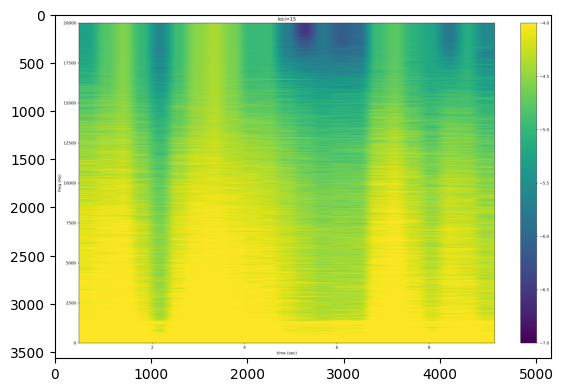

In [50]:
image_check = image.load_img("/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/STFT_domain_Oil_gas_D_top_left_loci_15/be22004_016/16_02_2022_12_36_41_00_hdf5.png")
target_size = (32,32)
plt.imshow(image_check)
plt.show()

In [51]:
# Step 2: Feature Extraction (Preprocessing + Spectrogram + Statistical Features)
def extract_features(image_path):
    # Load the image
    stft_image = load_stft_image(image_path)
    # Convert the image to grayscale if it's not already
    if len(stft_image.shape) == 3 and stft_image.shape[2] == 3:
        stft_image = cv2.cvtColor(stft_image, cv2.COLOR_BGR2GRAY)
    # Flatten the image array to 1-dimensional
    stft_image_flat = stft_image.flatten()
    # Compute the spectrogram
    f, t, Sxx = spectrogram(stft_image_flat, fs=1.0, nperseg=4)  # Adjust parameters as needed
    # Plot the spectrogram
    #plt.figure(figsize=(10, 5))
    #plt.imshow(Sxx, aspect='auto', cmap='jet', origin='lower')
    #plt.colorbar(label='Intensity')
    #plt.xlabel('Time')
    #plt.ylabel('Frequency')
    #plt.title('Spectrogram')
    #plt.show()
    # Extract statistical features from the frequency spectrum
    features = np.array([np.mean(Sxx), np.std(Sxx), np.median(Sxx), np.max(Sxx), np.min(Sxx)])
    return features

# Function to load STFT images
def load_stft_image(image_path):
    img = Image.open(image_path)
    # Convert the image to numpy array
    img_array = np.array(img)
    return img_array

In [52]:
# Extract features from images
X = []
y = []
for index, row in labels_df.iterrows():
    experiment_name = row['Experiment Number']
    bg_flow = row['Background Flow (m3/h)']
    gvf = row['GVF(%)']
    folder_path = os.path.join("/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/STFT_domain_Oil_gas_D_top_left_loci_15", experiment_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        features = extract_features(img_path)
        X.append(features)
        y.append([bg_flow, gvf])
X = np.array(X)
y = np.array(y)

In [53]:
# Reshape X to 2D
num_samples = X.shape[0]
X_flat = X.reshape(num_samples, -1)

# Create DataFrame
columns = [f'pixel_{i}' for i in range(X_flat.shape[1])]
df_features = pd.DataFrame(X_flat, columns=columns)

# Add Background Flow and GVF columns to the DataFrame
df_features['Background Flow'] = y[:, 0]
df_features['GVF'] = y[:, 1]

In [54]:
X

array([[ 7594.624 ,  8169.4595,  4294.0835, 46059.375 ,     0.    ],
       [ 7049.5083,  7636.8394,  4313.021 , 46059.375 ,     0.    ],
       [ 6637.9946,  7165.045 ,  4332.    , 46059.375 ,     0.    ],
       [ 6067.7427,  6445.39  ,  4250.6665, 46059.375 ,     0.    ],
       [ 6414.786 ,  6967.992 ,  4294.0835, 46059.375 ,     0.    ],
       [ 7638.2207,  8195.14  ,  4313.021 , 46059.375 ,     0.    ],
       [ 8360.023 ,  8776.633 ,  4373.3335, 46059.375 ,     0.    ],
       [ 6517.399 ,  7072.2886,  4313.021 , 46059.375 ,     0.    ],
       [ 7155.448 ,  7720.2197,  4332.    , 46059.375 ,     0.    ],
       [ 7923.987 ,  8313.806 ,  4332.    , 46059.375 ,     0.    ],
       [ 7420.8003,  7955.4844,  4332.    , 46059.375 ,     0.    ],
       [ 7715.2803,  8165.541 ,  4320.375 , 46059.375 ,     0.    ],
       [ 7743.7227,  8228.286 ,  4231.7085, 46059.375 ,     0.    ],
       [ 8296.74  ,  8611.815 ,  4370.0835, 46059.375 ,     0.    ],
       [ 8724.979 ,  8865.818 ,  4

In [55]:
df_features

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,Background Flow,GVF
0,7594.624023,8169.459473,4294.083496,46059.375,0.0,5,0
1,7049.508301,7636.839355,4313.020996,46059.375,0.0,5,0
2,6637.994629,7165.044922,4332.000000,46059.375,0.0,5,0
3,6067.742676,6445.390137,4250.666504,46059.375,0.0,5,0
4,6414.786133,6967.992188,4294.083496,46059.375,0.0,5,0
...,...,...,...,...,...,...,...
89,9305.765625,9289.157227,5026.708496,46059.375,0.0,30,63
90,9191.331055,9275.224609,5854.166504,46059.375,0.0,30,63
91,9781.163086,9551.421875,7105.333496,46059.375,0.0,30,63
92,8472.708008,8822.620117,4472.666504,46059.375,0.0,30,63


In [56]:
# Check if all features are same or different
feature_summary = df_features.describe()

# Display summary statistics
print(feature_summary)

# Check if all features are identical or not
are_features_identical = (feature_summary.loc['min'] == feature_summary.loc['max']).all()

if are_features_identical:
    print("All features are identical across samples.")
else:
    print("Features vary among samples.")


           pixel_0      pixel_1      pixel_2       pixel_3  pixel_4  \
count    94.000000    94.000000    94.000000     94.000000     94.0   
mean   7852.529297  8264.897461  4585.738770  46059.382812      0.0   
std    1248.507324   993.990540   709.547363      0.000000      0.0   
min    5436.124023  5683.257324  2655.187500  46059.375000      0.0   
25%    6717.444336  7520.299561  4313.020996  46059.375000      0.0   
50%    8185.325684  8582.233887  4373.333496  46059.375000      0.0   
75%    8853.997559  9041.518066  4857.140625  46059.375000      0.0   
max    9785.107422  9571.779297  7743.041504  46059.375000      0.0   

       Background Flow        GVF  
count        94.000000  94.000000  
mean         17.234043  23.617021  
std          12.564180  22.503575  
min           5.000000   0.000000  
25%           5.000000   5.000000  
50%           5.000000  16.000000  
75%          30.000000  42.000000  
max          30.000000  65.000000  
Features vary among samples.


In [57]:
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [58]:
# Step 4: Model Training
# Define the custom model
custom_model = Sequential()
custom_model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(128, activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(512, activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(1024, activation='relu'))
custom_model.add(Dropout(0.2))
custom_model.add(Dense(32, activation='relu'))
custom_model.add(Dense(2))  # Output layer with 2 neurons for Background Flow and GVF

# Compile the model
custom_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1536      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               66048     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1024)             

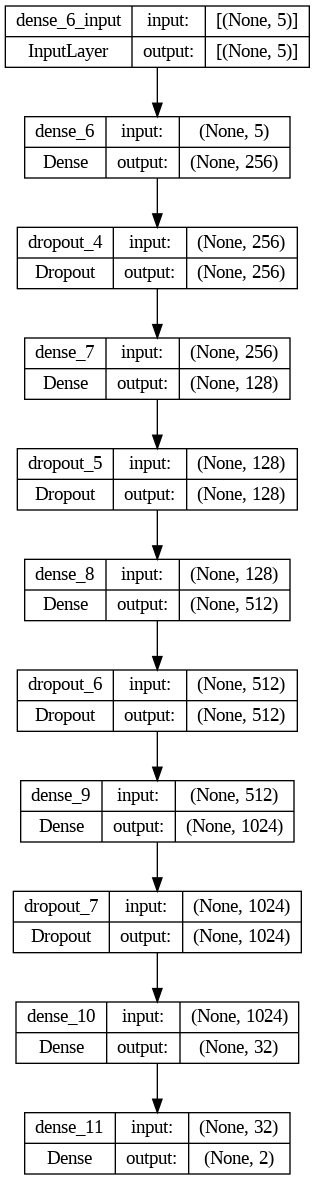

In [59]:
from tensorflow.keras.utils import plot_model

# Print the summary of the model
custom_model.summary()

# Save the model architecture as an image
plot_model(custom_model, to_file='custom_model.png', show_shapes=True)


In [60]:
# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = custom_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 860.5814 - mae: 21.7749 - val_loss: 681.0499 - val_mae: 20.5717
Epoch 2/20
1/1 [==============================] - 0s 99ms/step - loss: 846.0394 - mae: 21.5853 - val_loss: 672.0532 - val_mae: 20.4255
Epoch 3/20
1/1 [==============================] - 0s 86ms/step - loss: 826.8573 - mae: 21.3108 - val_loss: 659.1775 - val_mae: 20.2130
Epoch 4/20
1/1 [==============================] - 0s 84ms/step - loss: 803.3712 - mae: 20.9663 - val_loss: 640.8474 - val_mae: 19.9016
Epoch 5/20
1/1 [==============================] - 0s 85ms/step - loss: 762.9280 - mae: 20.3915 - val_loss: 615.3217 - val_mae: 19.4471
Epoch 6/20
1/1 [==============================] - 0s 91ms/step - loss: 715.4134 - mae: 19.6669 - val_loss: 581.1754 - val_mae: 18.7934
Epoch 7/20
1/1 [==============================] - 0s 95ms/step - loss: 645.9436 - mae: 18.6151 - val_loss: 538.1201 - val_mae: 17.8675
Epoch 8/20
1/1 [==============================] - 0s 95ms

In [61]:
# Step 5: Model Evaluation
# Evaluate the model on the test set
evaluation = custom_model.evaluate(X_test, y_test)
print("Evaluation Loss:", evaluation[0])
print("Evaluation MAE:", evaluation[1])

1/1 [==============================] - 0s 28ms/step - loss: 250.8797 - mae: 11.8348
Evaluation Loss: 250.87974548339844
Evaluation MAE: 11.834755897521973


In [62]:
print(history.history.keys())
history_model = pd.DataFrame({"loss": history.history['loss'], 'val_loss': history.history['val_loss'], 'mae': history.history['mae'], 'val_mae': history.history['val_mae']})

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [63]:
history_model

,loss,val_loss,mae,val_mae
0,860.581421,681.049866,21.774868,20.571672
1,846.039429,672.053162,21.585320,20.425537
2,826.857300,659.177490,21.310753,20.213041
3,803.371216,640.847351,20.966305,19.901602
4,762.927979,615.321655,20.391500,19.447054
5,715.413391,581.175415,19.666885,18.793415
6,645.943604,538.120117,18.615095,17.867479
7,560.316467,488.279510,17.612474,17.137527
8,476.676270,439.352203,16.806566,16.582104
9,377.260071,408.675446,15.735106,16.227808


In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Step 5: Model Evaluation

# Predictions for test set
predictions = custom_model.predict(X_test)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)



1/1 [==============================] - 0s 92ms/step
Mean Absolute Error (MAE): 11.83475610305523
Mean Squared Error (MSE): 250.87975400211207


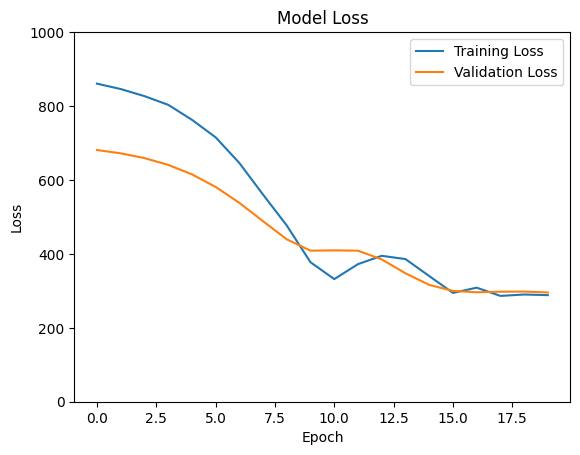

In [65]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1000)  # Set y-axis range
plt.show()

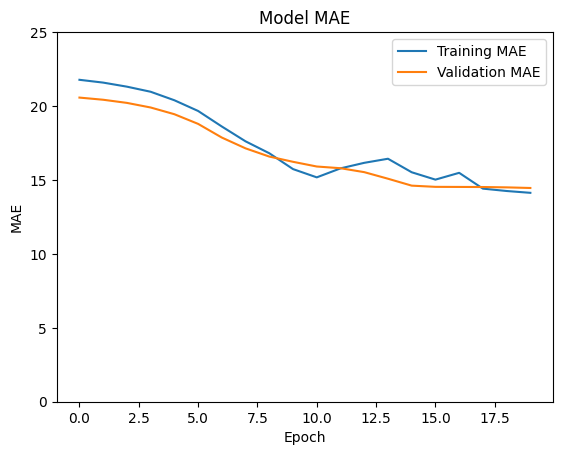

In [66]:
# Plot training & validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.ylim(0, 25)  # Set y-axis range
plt.show()


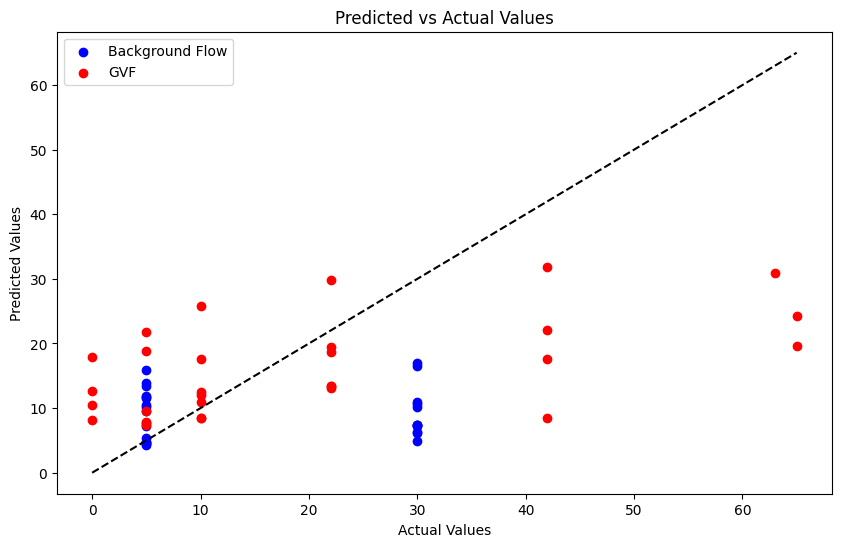

In [67]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], predictions[:, 0], color='blue', label='Background Flow')
plt.scatter(y_test[:, 1], predictions[:, 1], color='red', label='GVF')
plt.plot([min(y_test.min(), predictions.min()), max(y_test.max(), predictions.max())], [min(y_test.min(), predictions.min()), max(y_test.max(), predictions.max())], color='black', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

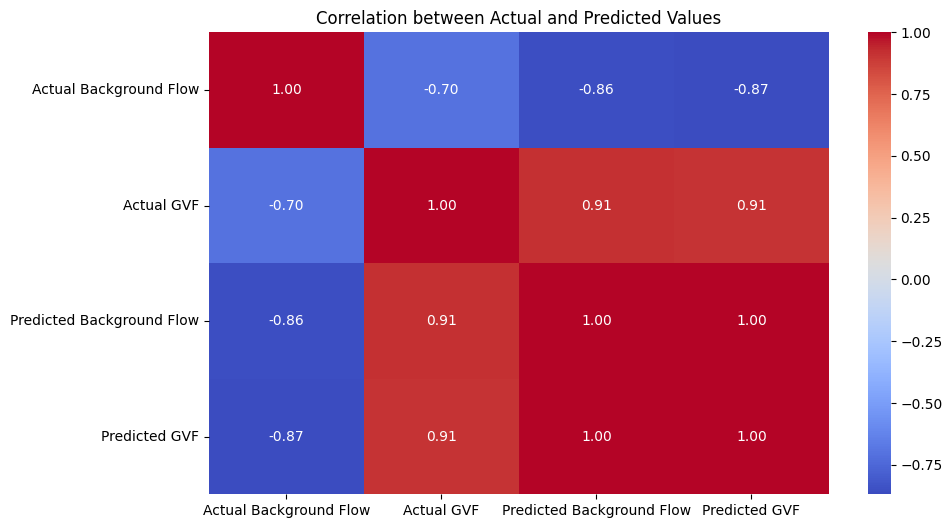

In [68]:
import seaborn as sns
# Heatmap of correlation between actual and predicted values
plt.figure(figsize=(10, 6))

# Add a small value to the diagonal of the covariance matrix
epsilon = 1e-9
cov_matrix = np.cov(np.concatenate((y_test, predictions), axis=1), rowvar=False) + epsilon * np.eye(4)

# Compute the correlation matrix
corr_matrix = np.corrcoef(cov_matrix)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=['Actual Background Flow', 'Actual GVF', 'Predicted Background Flow', 'Predicted GVF'],
            yticklabels=['Actual Background Flow', 'Actual GVF', 'Predicted Background Flow', 'Predicted GVF'])
plt.title('Correlation between Actual and Predicted Values')
plt.show()


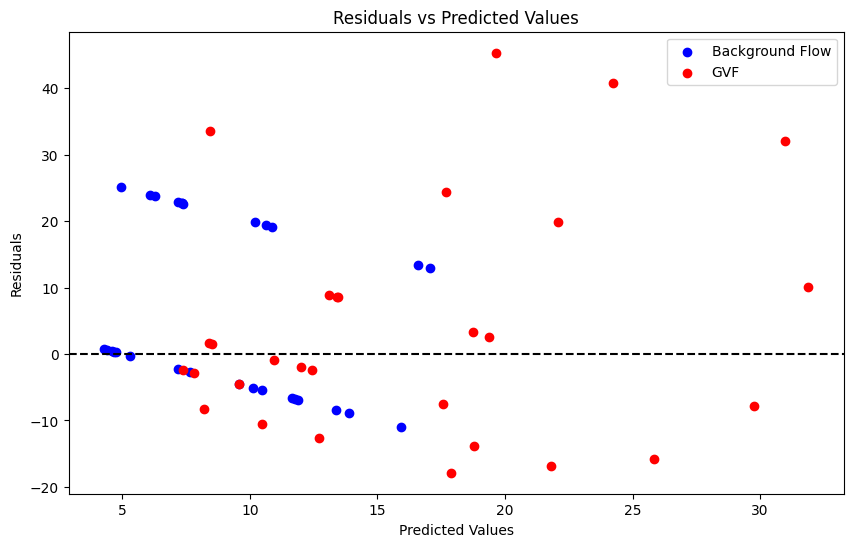

In [69]:
# Scatter plot of residuals vs predicted values
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions[:, 0], residuals[:, 0], color='blue', label='Background Flow')
plt.scatter(predictions[:, 1], residuals[:, 1], color='red', label='GVF')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [70]:
import math
def predict_single_image(image_path, model, scaler):
    # Extract features from the image
    features = extract_features(image_path)
    # Scale the features using the scaler used during training
    scaled_features = scaler.transform(features.reshape(1, -1))
    # Predict background flow and GVF
    prediction = model.predict(scaled_features)
    # Apply ReLU to ensure non-negativity
    prediction = np.maximum(prediction, 0)
    # Separate the predictions for background flow and GVF
    bg_flow_prediction = prediction[0][0]
    gvf_prediction = prediction[0][1]
    return bg_flow_prediction, gvf_prediction

# Example usage:
image_path = "/content/drive/MyDrive/Oil_GVF_prediction_CNN_models/STFT_domain_Oil_gas_D_top_left/be22004_016/16_02_2022_12_36_21_00_hdf5.png"  # Provide the path to your image
bg_flow_pred, gvf_pred = predict_single_image(image_path, custom_model, scaler)
print("Predicted Background Flow:", math.ceil(bg_flow_pred))
print("Predicted GVF:", math.ceil(gvf_pred))


1/1 [==============================] - 0s 36ms/step
Predicted Background Flow: 8
Predicted GVF: 13
